[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aymgal/herculens_workspace/blob/main/notebooks/herculens__Complex_lensed_source_with_fields.ipynb)

# Modeling a complex source with correlated fields

This notebooks shows the same example as in `herculens__Complex_lensed_source_with_wavelets_2.ipynb` but instead of a pixelated model using wavelets regularization, we model the source on a pixelated grid with a correlated field, fully forward model. 

__author__: @aymgal

__last updated__: 11/02/25

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Installing requirements and dependencies
    !pip install --quiet git+https://github.com/Herculens/herculens.git
    !pip install --quiet blackjax==0.9.6 numpyro==0.10.1 emcee==3.0.2
    !pip install --quiet jaxns dynesty getdist

In [30]:
# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm, Normalize, TwoSlopeNorm
plt.rc('image', interpolation='none')

# Basic imports
import os
from time import time
import numpy as np
from astropy.io import fits
from copy import deepcopy
from pprint import pprint
%matplotlib inline

from jax import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.distributions import constraints
from numpyro.infer import Predictive, SVI, Trace_ELBO, autoguide
from numpyro.distributions import constraints
from numpyro import infer
import optax

import herculens as hcl
from herculens.Util import image_util, param_util, plot_util

# Plotting engine
plotter = hcl.Plotter(flux_vmin=1e-3, flux_vmax=1e0, res_vmax=6)

In [3]:
seed = 18  # this one we fix all the time (data is unique)
key = jax.random.PRNGKey(seed)

## 1. Simulate an observation of a lensed source

### Data grids (image plane and source plane)
For simplicity at first, assume both share the same pixelization.

In [4]:
npix = 80  # number of pixel on a side
pix_scl = 0.08  # pixel size in arcsec
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2  # position of the (0, 0) with respect to bottom left pixel
transform_pix2angle = pix_scl * np.eye(2)  # transformation matrix pixel <-> angle
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}

# create the PixelGrid class
pixel_grid = hcl.PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
extent = pixel_grid.extent

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (80, 80) pixels
pixel size : 0.08 arcsec
x range    : (-3.16, 3.16) arcsec
y range    : (-3.16, 3.16) arcsec


### Point spread function (PSF)

For simplicity we assume here a Gaussian PSF.

In [5]:
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.15, 'pixel_size': pix_scl}
psf = hcl.PSF(**kwargs_psf)

### Noise

In [6]:
# exposure time, used for estimating the shot noise
exp_time = 2000
# standard deviation of the background noise
sigma_bkd = 0.005

kwargs_noise = {'background_rms': sigma_bkd, 'exposure_time': exp_time}
noise = hcl.Noise(npix, npix, **kwargs_noise)

### Lens model (SIE + external shear)

In [7]:
# Lens mass
lens_model_input = hcl.MassModel([hcl.SIE(), hcl.Shear()])

# position of the lens
cx0, cy0 = 0., 0.
# position angle, here in degree
phi = 8.0
# axis ratio, b/a
q = 0.75
# conversion to ellipticities
e1, e2 = param_util.phi_q2_ellipticity(phi * np.pi / 180, q)
# external shear orientation, here in degree
phi_ext = 54.0
# external shear strength
gamma_ext = 0.03 
# conversion to polar coordinates
gamma1, gamma2 = param_util.shear_polar2cartesian(phi_ext * np.pi / 180, gamma_ext)
kwargs_lens_input = [
    {'theta_E': 1.4, 'e1': e1, 'e2': e2, 'center_x': cx0, 'center_y': cy0},  # SIE
    {'gamma1': gamma1, 'gamma2': gamma2, 'ra_0': 0.0, 'dec_0': 0.0}  # external shear
]
#pprint(kwargs_lens_input)


# Lens light
#lens_light_model_input, kwargs_lens_light_input = None, [{}]
lens_light_model_input = None #LightModel(['SERSIC_ELLIPSE'])
kwargs_lens_light_input = [
    #{'amp': 8.0, 'R_sersic': 1.0, 'n_sersic': 3., 'e1': e1, 'e2': e2, 'center_x': cx0, 'center_y': cy0}
]
#pprint(kwargs_lens_light_input)

### Source galaxy

We construct use a galaxy merger observed with HST as realistic example of a complex source.

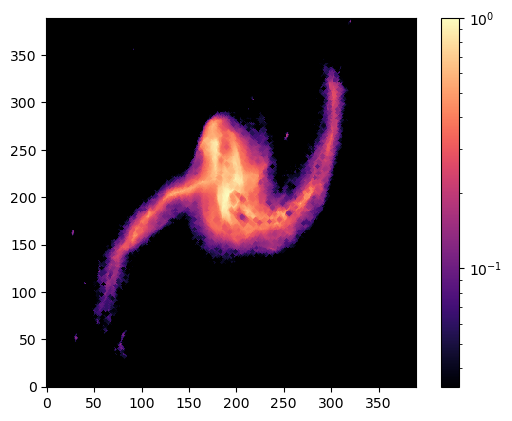

In [8]:
from skimage.transform import rescale
from skimage.morphology import erosion
merger = fits.getdata(os.path.join('data', 'NGC2623.fits'), header=False).astype(float)
merger = merger[100:-20, 20:-100]
merger = rescale(merger, 0.6, anti_aliasing=False)
merger[merger < 0] = 0

# clean small stellar clumps
merger = erosion(erosion(merger))

# we increase the contrast
#merger = np.log10(merger) + 1
#merger[merger < 0] = 0
merger[merger < 3e-2] = 0

# we normalize so that it is
merger /= merger.max()

plt.imshow(merger, origin='lower', cmap=plotter.cmap_flux, norm=LogNorm())
plt.colorbar()
plt.show()

In [9]:
merger_witdh = 2.
merger_pix_scl = merger_witdh / len(merger)
merger_position = (-0.2, 0)
kwargs_merger = {
    'grid_center': merger_position, # in arcsec
    'grid_shape': (merger_witdh, merger_witdh),  # in arcsec
    'pixel_scale_factor': merger_pix_scl / pix_scl,  # in arcsec
}
pprint(kwargs_merger)
source_model_input = hcl.LightModel(
    [
            hcl.PixelatedLight(
            interpolation_type='bicubic', 
            adaptive_grid=False,
            allow_extrapolation=False,
        )
    ], 
    kwargs_pixelated=kwargs_merger
)
amp_src = 3e-1
kwargs_source_input = [{'pixels': amp_src * merger}]

{'grid_center': (-0.2, 0),
 'grid_shape': (2.0, 2.0),
 'pixel_scale_factor': 0.0641025641025641}


### Generate the lens image

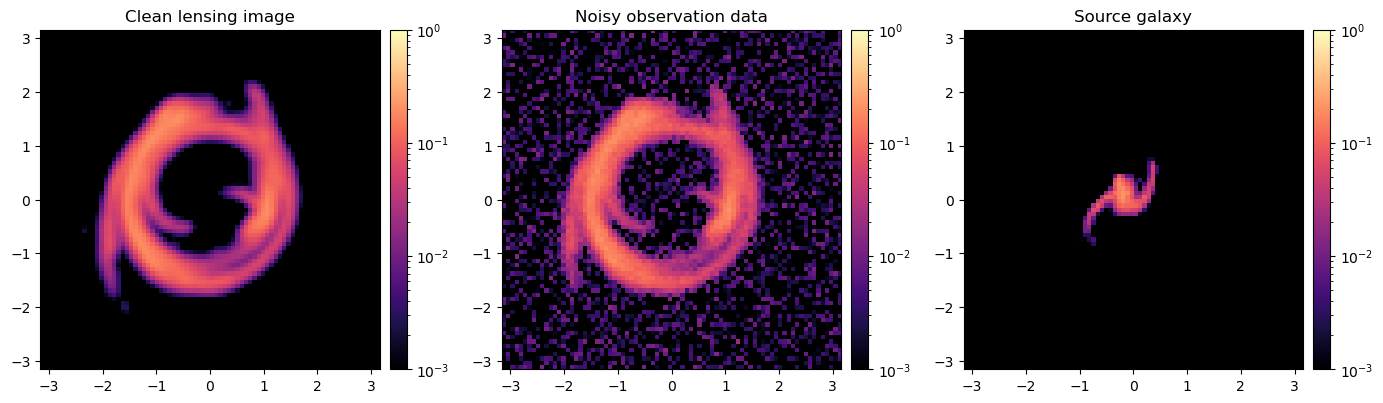

In [10]:
# Generate a lensed image based on source and lens models
kwargs_numerics_simu = {'supersampling_factor': 5}
lens_image_simu = hcl.LensImage(pixel_grid, psf, noise_class=noise,
                         lens_mass_model_class=lens_model_input,
                         source_model_class=source_model_input,
                         lens_light_model_class=lens_light_model_input,
                         kwargs_numerics=kwargs_numerics_simu)

kwargs_all_input = dict(kwargs_lens=kwargs_lens_input, 
                        kwargs_lens_light=kwargs_lens_light_input,
                        kwargs_source=kwargs_source_input)
image = lens_image_simu.model(**kwargs_all_input)

key, key_noise = jax.random.split(key)
data = lens_image_simu.simulation(**kwargs_all_input, compute_true_noise_map=True, prng_key=key_noise)

source_input = lens_image_simu.source_surface_brightness(kwargs_source_input, de_lensed=True, unconvolved=True)
#extent_src = lens_image_simu.SourceModel.pixel_grid.extent

# visualize simulated products
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
img1 = ax1.imshow(image, origin='lower', extent=extent, norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(img1)
ax1.set_title("Clean lensing image")
img2 = ax2.imshow(data, origin='lower', extent=extent, norm=plotter.norm_flux, cmap=plotter.cmap_flux)
ax2.set_title("Noisy observation data")
plot_util.nice_colorbar(img2)
img3 = ax3.imshow(source_input, origin='lower', extent=extent, norm=plotter.norm_flux, cmap=plotter.cmap_flux)
ax3.set_title("Source galaxy")
plot_util.nice_colorbar(img3)
fig.tight_layout()
plt.show()

## 2. Pixelated source reconstruction

### Create a model for fitting

In [11]:
# Setup the source model: pixelated on a regular grid
kwargs_pixelated_non_adaptive = {
    'pixel_scale_factor': 0.66,  # = data pixel size / source pixel size
    'grid_center': merger_position, 
    'grid_shape': (2.1, 2.1), # arcsec
}
# kwargs_pixelated_adaptive = {
#     'num_pixels': 100,
# }
source_model = hcl.LightModel(
    hcl.PixelatedLight(
        interpolation_type='fast_bilinear', 
        adaptive_grid=False,  # source grid extent will adapt using the arc mask
        allow_extrapolation=False,  # essentially says it should be zero outside the source grid
    ),
    kwargs_pixelated=kwargs_pixelated_non_adaptive,
)

kwargs_numerics_fit = {'supersampling_factor': 3}
lens_image = hcl.LensImage(deepcopy(pixel_grid), psf, noise_class=noise,
                       lens_mass_model_class=lens_model_input,
                       source_model_class=source_model,
                       lens_light_model_class=lens_light_model_input,
                       kwargs_numerics=kwargs_numerics_fit)

source_size = lens_image.SourceModel.pixel_grid.num_pixel
source_shape = lens_image.SourceModel.pixel_grid.num_pixel_axes
print(source_shape, source_size)

(40, 40) 1600


In [12]:
# inform the plotter of the data
plotter.set_data(data)

# inform the plotter about the true source (on the pixelated grid)
x_grid_src, y_grid_src = lens_image.SourceModel.pixel_grid.pixel_coordinates
source_input_fitgrid = lens_image_simu.SourceModel.surface_brightness(x_grid_src, y_grid_src, kwargs_source_input)
source_input_fitgrid *= lens_image.Grid.pixel_area
plotter.set_ref_source(source_input_fitgrid)

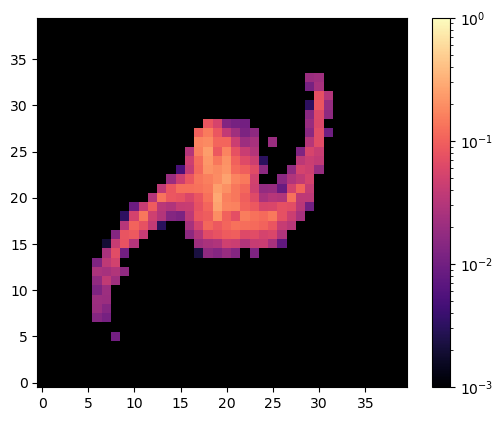

In [13]:
plt.imshow(source_input_fitgrid, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plt.colorbar()
plt.show()

### Define the correlated field prior

The current interface to the correlated field is to define it as a standalone forward modelling object, that can then be called within the numpyro model defined right after, pugged in as the source pixels.

In [14]:
source_field = hcl.CorrelatedField(
    "source_pixels", 
    source_model, 
    offset_mean=-5., # NOTE: this is the log of the offset because exponentiate=True!
    prior_offset_std=(0.5, 1e-6),
    prior_loglogavgslope=(-4., 0.5), 
    prior_fluctuations=(1.5, 0.8),
    prior_flexibility=None,
    prior_asperity=None,
    cropped_border_size=0,
    exponentiate=True,
)

Exponential Cropped correlated field prior for 'source_pixels'


### Create the probabilistic model

In [15]:
class MyProbModel(hcl.NumpyroModel):
    
    def __init__(self, fix_lens_mass=False):
        self._fix_lens_mass = fix_lens_mass
    
    def model(self):
        # Parameters of the source
        prior_source = [{'pixels': source_field.numpyro_sample_pixels()}]

        # Parameters of the lens
        cx = 0. # numpyro.sample('lens_center_x', dist.Normal(0., 0.02))
        cy = 0. # numpyro.sample('lens_center_y', dist.Normal(0., 0.02))
        if self._fix_lens_mass is True:
            prior_lens = kwargs_lens_input
        else:
            prior_lens = [
            {
                # SIE
                'theta_E': numpyro.sample('lens_theta_E', dist.Normal(kwargs_lens_input[0]['theta_E'], 0.1)),
                'e1': numpyro.sample('lens_e1', dist.TruncatedNormal(kwargs_lens_input[0]['e1'], 0.05, low=-0.3, high=0.3)),
                'e2': numpyro.sample('lens_e2', dist.TruncatedNormal(kwargs_lens_input[0]['e2'], 0.05, low=-0.3, high=0.3)),
                'center_x': cx, 
                'center_y': cy
            },
            {
                # external shear
                'gamma1': numpyro.sample('lens_gamma1', dist.TruncatedNormal(kwargs_lens_input[1]['gamma1'], 0.05, low=-0.3, high=0.3)), 
                'gamma2': numpyro.sample('lens_gamma2', dist.TruncatedNormal(kwargs_lens_input[1]['gamma2'], 0.05, low=-0.3, high=0.3)), 
                'ra_0': 0.0, 'dec_0': 0.0
            }
        ]
        
        # wrap up all parameters for the lens_image.model() method
        model_params = dict(kwargs_lens=prior_lens, 
                            kwargs_source=prior_source)
        
        # generates the model image
        model_image = lens_image.model(**model_params)
        
        # estimate the error per pixel
        model_error = jnp.sqrt(noise.C_D_model(model_image))
        
        # finally defines the observed node, conditioned on the data assuming a Gaussian distribution
        numpyro.sample('obs', dist.Independent(dist.Normal(model_image, model_error), 2), obs=data)

    def params2kwargs(self, params):
        if self._fix_lens_mass is True:
            kwargs_lens = kwargs_lens_input
        else:
            kwargs_lens = [
                {
                    'theta_E': params['lens_theta_E'],
                    'e1': params['lens_e1'],
                    'e2': params['lens_e2'],
                    'center_x': 0., #params['lens_center_x'],
                    'center_y': 0., #params['lens_center_y'],
                },
                {
                    'gamma1': params['lens_gamma1'],
                    'gamma2': params['lens_gamma2'],
                    'ra_0': 0.0, 'dec_0': 0.0
                }
            ] 
        kw = {
            'kwargs_lens': kwargs_lens,
            'kwargs_source': [{'pixels': source_field.model(params)}],
        }
        return kw

Optimizing the lens mass parameters also works fine. However it causes the parameter space to be way too complex for the very basic variational inference (SVI with only Normal distribution guide) run that we performed right after.

In [16]:
prob_model = MyProbModel(fix_lens_mass=False)

n_param = prob_model.num_parameters
print("Number of parameters:", n_param)

loss = hcl.Loss(prob_model)

Number of parameters: 1608


Loss at initial values: 95827.96314161246


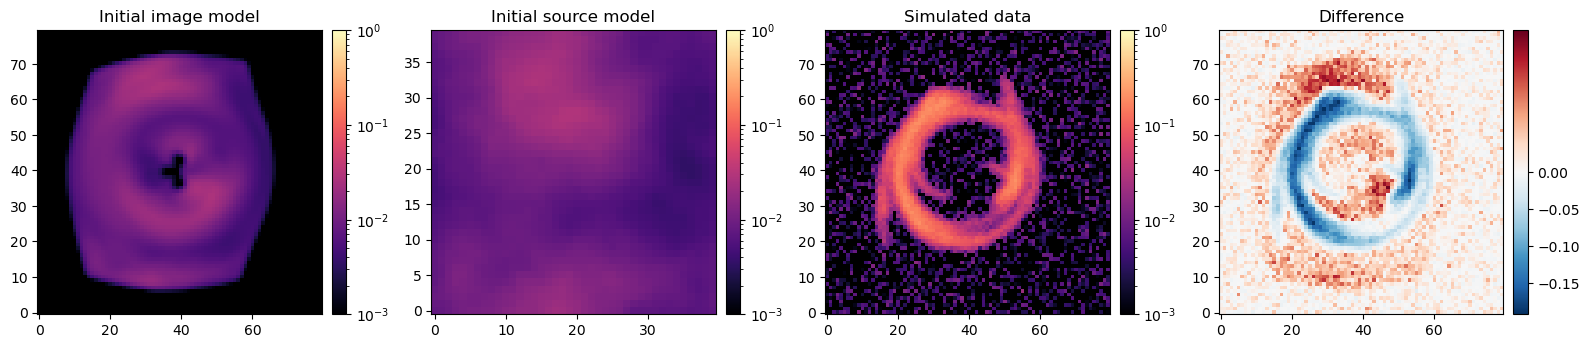

In [17]:
key, key_init = jax.random.split(key)
init_params = prob_model.get_sample(prng_key=key_init)
kwargs_init = prob_model.params2kwargs(init_params)
#pprint(kwargs_init)

# get initial parameters in uncontrainted space
init_params_unconst = prob_model.unconstrain(init_params)

print("Loss at initial values:", loss(init_params_unconst))

# visualize initial guess
initial_model = lens_image.model(**kwargs_init)
initial_source = lens_image.SourceModel.surface_brightness(x_grid_src, y_grid_src, kwargs_init['kwargs_source']) * lens_image.Grid.pixel_area

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
ax = axes[0]
ax.set_title("Initial image model")
im = ax.imshow(initial_model, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(im)
ax = axes[1]
ax.set_title("Initial source model")
im = ax.imshow(initial_source, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(im)
ax = axes[2]
ax.set_title("Simulated data")
im = ax.imshow(data, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(im)
ax = axes[3]
ax.set_title("Difference")
im = ax.imshow(initial_model - data, origin='lower', norm=TwoSlopeNorm(0), cmap=plotter.cmap_res)
plot_util.nice_colorbar(im)
fig.tight_layout()
plt.show()

### Minimise the loss function using `optax`

We use the adaptive gradient descent algorithm AdaBelief to optimize the values of all source pixels.

In [18]:
optimizer = hcl.OptaxOptimizer(loss, loss_norm_optim=data.size)

# optimizer settings
max_iterations = 5_000
init_learning_rate = 1e-3

best_fit_unconst, logL, extra_fields, runtime \
    = optimizer.run(init_params_unconst, max_iterations=max_iterations, 
                    init_learning_rate=init_learning_rate)
print(f"Runtime: {runtime}")
print("Loss at best-fit:", loss(best_fit_unconst))

optax.adabelief: 100%|██████████| 5000/5000 [00:49<00:00, 100.18it/s]


Runtime: 49.93145394325256
Loss at best-fit: -22764.099874790707


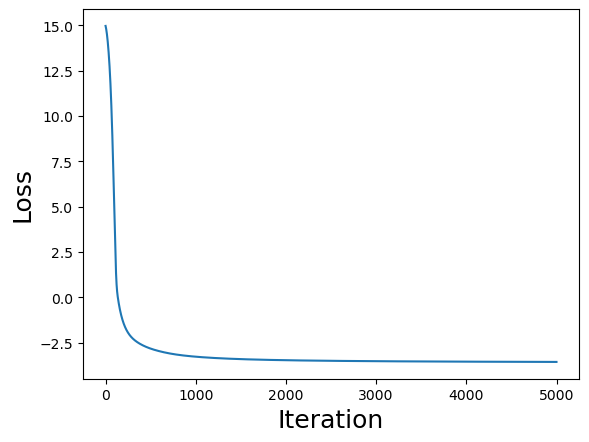

In [19]:
best_fit = prob_model.constrain(best_fit_unconst)
kwargs_bestfit = prob_model.params2kwargs(best_fit)

fig, ax = plt.subplots(1, 1)
ax.plot(range(len(extra_fields['loss_history'])), extra_fields['loss_history'])
ax.set_ylabel("Loss", fontsize=18)
ax.set_xlabel("Iteration", fontsize=18)
plt.show()

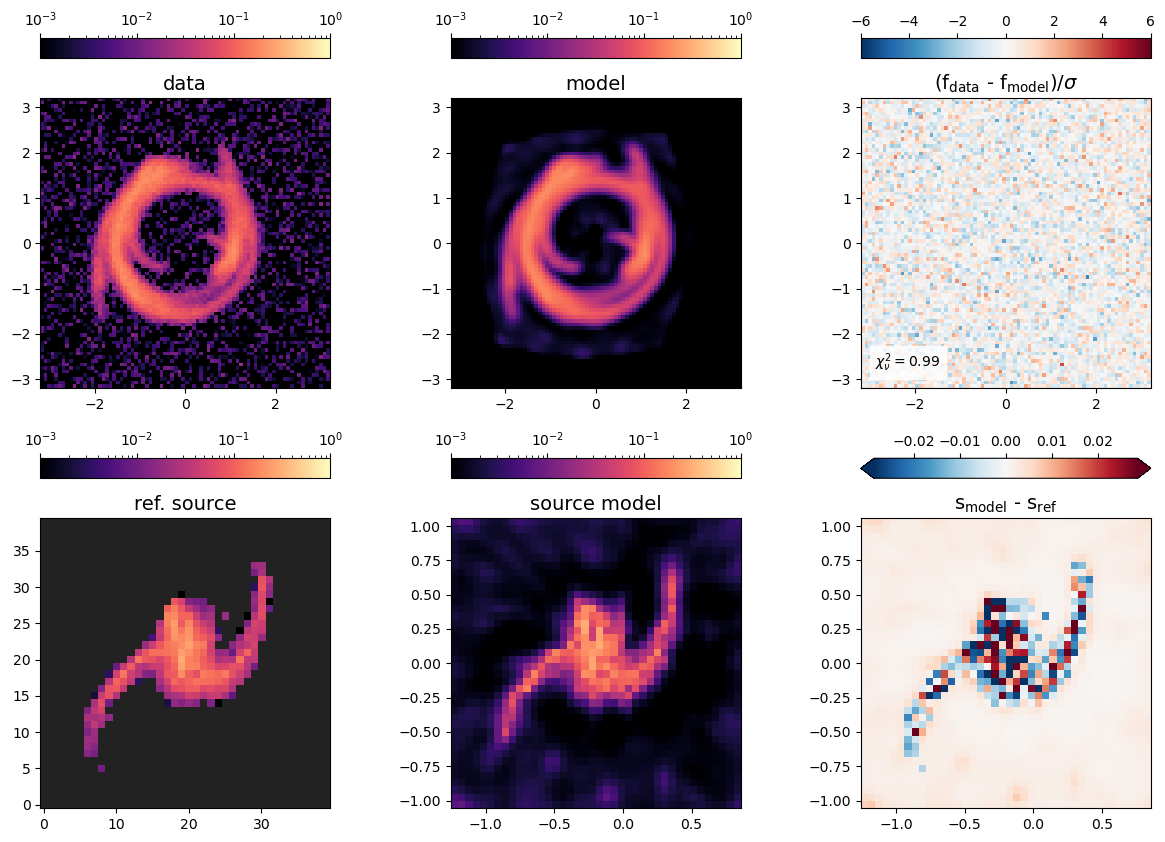

In [20]:
fig = plotter.model_summary(lens_image, kwargs_bestfit)
plt.show()

In [21]:
model_pixels = kwargs_bestfit['kwargs_source'][0]['pixels']
print("min & max source model:", model_pixels.min(), model_pixels.max())

#plt.imshow(model_pixels, norm=Normalize(), cmap=plotter.cmap_flux)
#plt.colorbar()

min & max source model: 0.0005387270440142844 0.30306689556186384


In [22]:
pprint(kwargs_lens_input)

[{'center_x': 0.0,
  'center_y': 0.0,
  'e1': Array(0.1373231, dtype=float64, weak_type=True),
  'e2': Array(0.03937677, dtype=float64, weak_type=True),
  'theta_E': 1.4},
 {'dec_0': 0.0,
  'gamma1': Array(-0.00927051, dtype=float64, weak_type=True),
  'gamma2': Array(0.0285317, dtype=float64, weak_type=True),
  'ra_0': 0.0}]


In [23]:
pprint(kwargs_bestfit['kwargs_lens'])

[{'center_x': 0.0,
  'center_y': 0.0,
  'e1': Array(0.13634922, dtype=float64),
  'e2': Array(0.04250921, dtype=float64),
  'theta_E': Array(1.40061634, dtype=float64)},
 {'dec_0': 0.0,
  'gamma1': Array(-0.01028632, dtype=float64),
  'gamma2': Array(0.02994062, dtype=float64),
  'ra_0': 0.0}]


### Variational inference for a (rough) approximation of the posterior

In [31]:
max_iterations_svi = 2_000

# Initialization of SVI
init_fun_svi = infer.init_to_median(num_samples=25) # start from the median of prior
# init_fun_svi = infer.init_to_value(
#     values=best_fit,
# )  # start at the given parameters values

# Model (likelihoods and priors)
model_svi = prob_model.model

# Guide (posterior model)
guide_svi = autoguide.AutoLowRankMultivariateNormal(
    model_svi,
    init_loc_fn=init_fun_svi
)

# This is just an example scheduler
# playing around with `transition_steps` can help
# the SVI results
scheduler = optax.exponential_decay(
    init_value=0.01,
    decay_rate=0.99,
    transition_steps=50
)

# Other optimizations functions might work better for your
# problem, adabelief worked best for ours
optim_svi = optax.adabelief(learning_rate=scheduler)
loss_svi = infer.TraceMeanField_ELBO(num_particles=1)

# make the SVI class object
svi = infer.SVI(
    model_svi,
    guide_svi,
    optim_svi,
    loss_svi,
)

print("Start training guide...")
svi_result = svi.run(jax.random.PRNGKey(1), max_iterations_svi)
print("Finish training guide. Extract samples...")

Start training guide...


100%|██████████| 2000/2000 [00:29<00:00, 68.61it/s, init loss: 108764.1531, avg. loss [1901-2000]: -22061.5001]


Finish training guide. Extract samples...


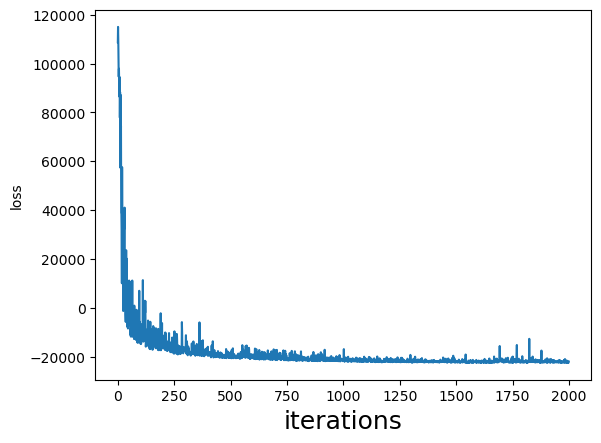

In [32]:
# check convergence
plt.plot(svi_result.losses)
plt.xlabel("iterations", fontsize=18)
plt.ylabel("loss")
plt.show()

In [35]:
num_samples = 5_000
posterior_samples = guide_svi.sample_posterior(
    jax.random.PRNGKey(2), svi_result.params, 
    sample_shape=(num_samples,)
)

guide_median = guide_svi.median(svi_result.params)

# you could also sample from the prior for comparison
#prior_samples = prob_model.sample_prior(num_samples, seed=18)

# maximum-a-posterior (MAP) estimate
model_map = kwargs_bestfit['kwargs_source'][0]['pixels']

# median
model_median = prob_model.params2kwargs(guide_median)['kwargs_source'][0]['pixels']

# mean and standard deviation
posterior_images = jax.vmap(prob_model.params2kwargs)(posterior_samples)['kwargs_source'][0]['pixels']
model_mean = np.mean(posterior_images, axis=0)
model_std = np.std(posterior_images, axis=0)

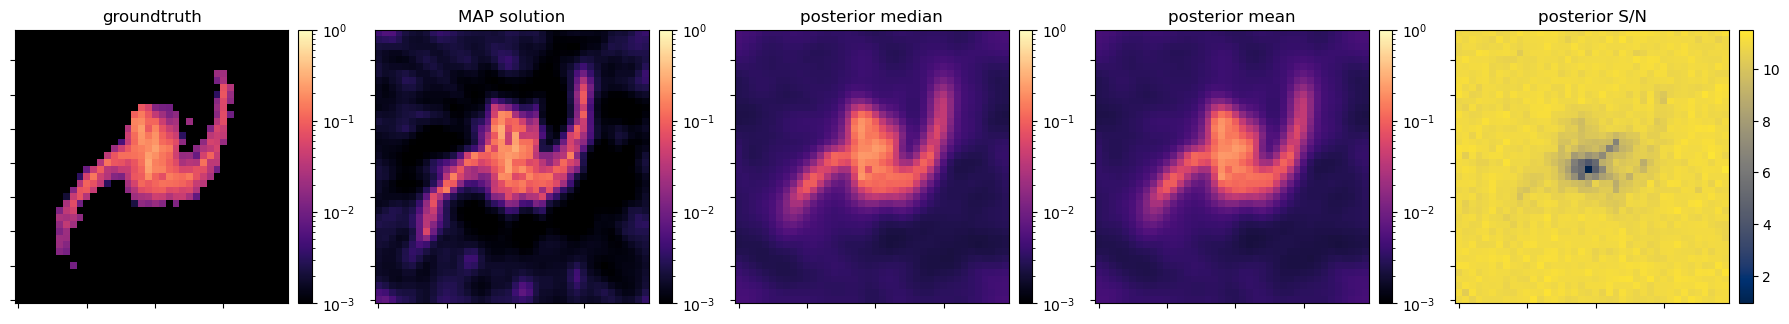

In [37]:
norm = LogNorm(1e-3, 1e0)

fig, axes = plt.subplots(1, 5, figsize=(18, 4))
ax = axes[0]
ax.set_title("groundtruth")
im = ax.imshow(source_input_fitgrid, origin='lower', cmap=plotter.cmap_flux, norm=norm)
plot_util.nice_colorbar(im)
ax.set_xticklabels([]);ax.set_yticklabels([])

ax = axes[1]
ax.set_title("MAP solution")
im = ax.imshow(model_map, origin='lower', cmap=plotter.cmap_flux, norm=norm)
plot_util.nice_colorbar(im)
ax.set_xticklabels([]);ax.set_yticklabels([])

ax = axes[2]
ax.set_title("posterior median")
im = ax.imshow(model_median, origin='lower', cmap=plotter.cmap_flux, norm=norm)
plot_util.nice_colorbar(im)
ax.set_xticklabels([]);ax.set_yticklabels([])

ax = axes[3]
ax.set_title("posterior mean")
im = ax.imshow(model_mean, origin='lower', cmap=plotter.cmap_flux, norm=norm)
plot_util.nice_colorbar(im)
ax.set_xticklabels([]);ax.set_yticklabels([])
# ax.set_title("SNR")
# im = ax.imshow(np.abs(model_mean) / model_std, origin='lower', cmap='viridis', norm=Normalize())
# plot_util.nice_colorbar(im)
# ax.set_xticklabels([]);ax.set_yticklabels([])

ax = axes[4]
ax.set_title("posterior S/N")
im = ax.imshow(model_mean / model_std, origin='lower', cmap='cividis', norm=Normalize())
plot_util.nice_colorbar(im)
ax.set_xticklabels([]);ax.set_yticklabels([])

plt.tight_layout()
plt.show()